The training is done in three stages:  
1) Train on all data, we need to get the error to be less than 1.9.
2) Based on the sentence corpus, the best solution is calculated using validation data. Polishing the model.
3) Based on the corpus with 5 sentences (or paragraphs), the best solution is calculated using validation data. To teach nllb-200 to handle multiple sentences.

And then the best model is selected based on the metrics: ChRF++ and Blue

# 1.Libraries -----------------------------

In [ ]:
!pip install sentencepiece==0.1.99 transformers==4.33.2 datasets sacremoses sacrebleu  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00


In [ ]:
import os
import json
import random
import torch
import nltk
import gc
import unicodedata
import re
import sys
import typing as tp
import numpy as np
import pandas as pd
from datasets import load_dataset
import sacrebleu
from sacremoses import MosesPunctNormalizer
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup
from tqdm.auto import tqdm, trange

# 2.CONSTANTS -----------------------------

In [ ]:
from google.colab import drive
drive.mount('/Til')

Mounted at /Til


In [ ]:
PATH = '/Til/MyDrive/Colab Notebooks/Til/'
DATA_PATH = "TSjB/qarachay-malqar_russian_parallel_corpora_dialectic-free"
DATA_NAME = "All.csv"

SOURCE_MODEL = 'TSjB/NLLB-201-600M-QM-V1'
MODEL_PATH = "".join([PATH, 'models/NLLB_v2/'])

MODEL_PATH_RAW = "".join([MODEL_PATH, 'nllb_krc_raw'])
MODEL_PATH_QM_ALL = "".join([MODEL_PATH, 'nllb_qm_v2_all'])
MODEL_PATH_QM_ONE = "".join([MODEL_PATH, 'nllb_qm_v2_one'])
MODEL_PATH_QM_SEV = "".join([MODEL_PATH, 'nllb_qm_v2_sev'])
MODEL_PATH_QM_ONE_FULL = "".join([MODEL_PATH, 'nllb_qm_v2_one_full'])

LANG_UNICODE = 'krc_Cyrl'
SRC_LANG = "krc_Cyrl"
TRG_LANG = "rus_Cyrl"

SHARE_VAL = 0.25
SHARE_TEST = 0.05

MAX_LENGTH = 256 # 512

SRC_LANG_DF = SRC_LANG.removesuffix("_Cyrl")
TRG_LANG_DF = TRG_LANG.removesuffix("_Cyrl")

LANGS = [(TRG_LANG_DF, TRG_LANG), (SRC_LANG_DF, SRC_LANG)]

# 3.LOAD MODEL -----------------------------

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(SOURCE_MODEL) # MODEL_PATH_RAW
model = AutoModelForSeq2SeqLM.from_pretrained(SOURCE_MODEL) # MODEL_PATH_RAW

if torch.cuda.is_available():
    model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/5.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

# 4.LOAD DATASETS -----------------------------

In [ ]:
all_data = load_dataset(DATA_PATH, data_files = DATA_NAME, sep = ';')
all_data = pd.DataFrame(all_data['train'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
all_data.type.unique()

array(['one_sentence', 'one_word', 'several_sentences'], dtype=object)

In [ ]:
one_sentence = all_data[all_data.type == 'one_sentence']
several_sentences = all_data[all_data.type == 'several_sentences']

In [ ]:
def splitDataset(df):
  num_test_samples = round(SHARE_TEST * len(df))
  num_val_samples = round(SHARE_VAL * len(df))
  num_train_samples = len(df) - num_val_samples - num_test_samples

  vec_types = ["train"] * num_train_samples + ["test"] * num_test_samples +  ["val"] * num_val_samples
  pair_group = random.sample(vec_types, len(vec_types))

  test_pairs = df[[(a == "test") for a in pair_group]]
  train_pairs = df[[(a == "train") for a in pair_group]]
  valid_pairs = df[[(a == "val") for a in pair_group]]

  return (train_pairs, valid_pairs, test_pairs)

In [ ]:
train_all_sentences = all_data
train_all, valid_all, test_all = splitDataset(df = all_data)
train_one, valid_one, test_one = splitDataset(df = one_sentence)
train_sev, valid_sev, test_sev = splitDataset(df = several_sentences)

In [ ]:
train_all[:10]

,krc,rus,short_source,source,type
0,Теnиз тузлу некди?,Почему море солёное?,jomaq,"Сказки из приложения ""Джомакъла""",one_sentence
1,Бир jашчыq анасы бла тиnизге jуwунурgа барgанды.,Один мальчик со своей мамой на море купаться п...,jomaq,"Сказки из приложения ""Джомакъла""",one_sentence
2,"Jашчыq qуwаныb, суwgа кёмюлсе, аwузуна суw кир...","Мальчик был рад, в воду вошёл, вода в рот поп...",jomaq,"Сказки из приложения ""Джомакъла""",one_sentence
4,Суwну алай тузлу нек болgанын аnыламай:,Вода почему стала солёной он не понял:,jomaq,"Сказки из приложения ""Джомакъла""",one_sentence
5,- Некди теnиз былай тузлу? – деb сейирсинnенди.,- Почему вода такая солёная? – он поинтересова...,jomaq,"Сказки из приложения ""Джомакъла""",one_sentence
10,"Jарлы, аны юйюнден чыgыb, мыдах болуb, келе ту...","Бедный, покинув дом, приуныв, шёл и в это врем...",jomaq,"Сказки из приложения ""Джомакъла""",one_sentence
11,- Не айланаса? – деb сорgан кишичик.,- Ты бродяга? – спросил мужчина.,jomaq,"Сказки из приложения ""Джомакъла""",one_sentence
13,"- Ма, бу гырjынчыqны ал да, таw артына бар.","- На, это кусок хлеба возьми и за гору иди.",jomaq,"Сказки из приложения ""Джомакъла""",one_sentence
16,"Андан арысын кёре барырса, - деb кишичик гырjы...","Оттуда дальше пойдёшь, - сказал мужчина, дав е...",jomaq,"Сказки из приложения ""Джомакъла""",one_sentence
17,"Jарлы qарнаш таw артына аwgанды, ол адамчыqлаg...","Бедный брат за гору прошёл, он человечков встр...",jomaq,"Сказки из приложения ""Джомакъла""",one_sentence


# 5.PREPARING TOKENIZER -----------------------------

Because language ids are added by hard-code on initialization, we need to manually fix them.

In [ ]:
def fixTokenizer(tokenizer, new_lang=LANG_UNICODE):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
fixTokenizer(tokenizer)

NameError: name 'tokenizer' is not defined

Checking

In [ ]:
print(tokenizer.convert_ids_to_tokens([262923, 262924, 262925])) # ['zul_Latn', 'krc_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'krc_Cyrl', '<mask>'])) # [262923, 262924, 262925]

In [ ]:
for token_id in range(len(tokenizer.sp_model), len(tokenizer)):
    token = tokenizer.convert_ids_to_tokens(token_id)
    print(token_id, token)

262721 

262722 ace_Arab
262723 ace_Latn
262724 acm_Arab
262725 acq_Arab
262726 aeb_Arab
262727 afr_Latn
262728 ajp_Arab
262729 aka_Latn
262730 amh_Ethi
262731 apc_Arab
262732 arb_Arab
262733 ars_Arab
262734 ary_Arab
262735 arz_Arab
262736 asm_Beng
262737 ast_Latn
262738 awa_Deva
262739 ayr_Latn
262740 azb_Arab
262741 azj_Latn
262742 bak_Cyrl
262743 bam_Latn
262744 ban_Latn
262745 bel_Cyrl
262746 bem_Latn
262747 ben_Beng
262748 bho_Deva
262749 bjn_Arab
262750 bjn_Latn
262751 bod_Tibt
262752 bos_Latn
262753 bug_Latn
262754 bul_Cyrl
262755 cat_Latn
262756 ceb_Latn
262757 ces_Latn
262758 cjk_Latn
262759 ckb_Arab
262760 crh_Latn
262761 cym_Latn
262762 dan_Latn
262763 deu_Latn
262764 dik_Latn
262765 dyu_Latn
262766 dzo_Tibt
262767 ell_Grek
262768 eng_Latn
262769 epo_Latn
262770 est_Latn
262771 eus_Latn
262772 ewe_Latn
262773 fao_Latn
262774 pes_Arab
262775 fij_Latn
262776 fin_Latn
262777 fon_Latn
262778 fra_Latn
262779 fur_Latn
262780 fuv_Latn
262781 gla_Latn
262782 gle_Latn
262783 glg_Latn

# 6.FUNCTIONS -----------------------------

### 6.1.PREPROC -----------------------------

In [ ]:
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

### 6.2. OTHER -----------------------------

In [ ]:
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

def getBatchPairs(batch_size, data, step=None):

    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    if step == None:
      for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    else:
      batch_data = data[step * batch_size: (step + 1) * batch_size]
      xx=preproc(batch_data[l1].to_list())
      yy=preproc(batch_data[l2].to_list())

    return xx, yy, long1, long2

print(getBatchPairs(4, data=train_all_sentences, step=4))

("['Андан арысын кёре барырса, - деb кишичик гырjынчыgын да jашха тутдуруb, jолуна кетеди.', 'Jарлы qарнаш таw артына аwgанды, ол адамчыqлаgа тюлбегенди.', 'Сёлешгендиле, танышхандыла.', '- Бизге бер! - деb ала муну гырjынчыgын бир аwуздан тилегендиле.']", "['Оттуда дальше пойдёшь, - сказал мужчина, дав еду парню, и ушёл своей дорогой.', 'Бедный брат за гору прошёл, он человечков встретил.', 'Поговорили, познакомились.', '- Нам дай! - они хлеба попросили.']", 'krc_Cyrl', 'rus_Cyrl')


### 6.3.TRAIN FUNCTION -----------------------------

* batch_size                - Size of batch
* checkpoint_steps          - After how many iterations to check and report
* n_non_improve_val_perplex - Number of subsequent training checkpoints if there are no improvements in validation perplexity
* val_amount_test           - Number of tests for validation
* steps                     - Number of steps for training
* data_train                - Train dataset
* data_validation           - Validation dataset
* model_path                - Path to save model
* random_batch              - Is it need to train all data or random one?  
You need to initialize: losses and val_losses - they are the global variable

In [ ]:
def trainModel(batch_size, checkpoint_steps, steps, data_train, model_path, data_validation=None, n_non_improve_val_perplex=None, val_amount_test=None, random_batch=True):
  train_data = data_train.sample(frac = 1)
  x, y, loss, loss_val  = None, None, None, None
  last_val_best_loss_perpl = float("Inf")
  improve_iter = 0

  tq = trange(len(losses), steps)
  for i in tq:
    if random_batch == True:
      xx, yy, lang1, lang2 = getBatchPairs(batch_size, data = train_data)
    else:
      xx, yy, lang1, lang2 = getBatchPairs(batch_size, data = train_data, step=i)

    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % checkpoint_steps == 0:
      # if (data_validation != None) & (n_non_improve_val_perplex != None) & (val_amount_test != None):
      if (n_non_improve_val_perplex != None) & (val_amount_test != None):
        for _ in range(0, val_amount_test):
          xx, yy, lang1, lang2 = getBatchPairs(batch_size, data = data_validation)

          try:
            tokenizer.src_lang = lang1
            x_val = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH).to(model.device)
            tokenizer.src_lang = lang2
            y_val = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH).to(model.device)
            y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

            loss_val = model(**x_val, labels=y_val.input_ids).loss
            val_losses.append(loss_val.item())

          except RuntimeError as e:
            optimizer.zero_grad(set_to_none=True)
            x, y, loss, loss_val  = None, None, None, None
            cleanup()
            print('error', max(len(s) for s in xx + yy), e)
            continue

        train_loss = np.mean(losses[-checkpoint_steps:])
        train_perp = np.mean(np.exp(losses[-checkpoint_steps:]))
        val_loss = np.mean(val_losses[-val_amount_test:])
        val_perp = np.mean(np.exp(val_losses[-val_amount_test:]))
        # val_blue = np.mean(blue_val)
        # val_chrf = np.mean(chrf_losses)

        print('Step:', i, '/', steps, '; loss:', train_loss, '; validation loss:', val_loss,'; perplexity:', train_perp, '; validation perplexity:', val_perp)


        # Update control values and save best result
        if val_perp < last_val_best_loss_perpl:
          last_val_best_loss_perpl = val_perp
          improve_iter = i
          print('Save model')
          # model.save_pretrained(model_path, force_download=True)
          # tokenizer.save_pretrained(model_path, force_download=True)
          model.save_pretrained(model_path)
          tokenizer.save_pretrained(model_path)

        # Stop cycle
        if (i - improve_iter) >= (n_non_improve_val_perplex * checkpoint_steps):
          print('Break')
          break

      else:
        train_loss = np.mean(losses[-checkpoint_steps:])
        train_perp = np.mean(np.exp(losses[-checkpoint_steps:]))
        print('Step:', i, '/', steps, '; loss:', train_loss, '; perplexity:', train_perp)

        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

# 7.TRAIN -----------------------------

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)

model.train()

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(262926, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(262926, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

### 7.1.TRAIN ALL -----------------------------

Here we need to get the error to be less than 1.9, so run one to several times

In [ ]:
batch_size = 32 # 32
checkpoint_steps = 500 # 1
n_non_improve_val_perplex = 7 # Number of subsequent training checkpoints if there is no improvement in validation perplexity
val_amount_test = 10 # Number of tests for validation
epoches = 1

  0%|          | 0/1 [00:00<?, ?it/s]

epoch  0 / 1


  0%|          | 0/9034 [00:00<?, ?it/s]

Step: 0 / 9034 ; loss: 2.052159547805786 ; perplexity: 7.784694386515681
Step: 500 / 9034 ; loss: 2.1270002822875975 ; perplexity: 9.300724689625367
Step: 1000 / 9034 ; loss: 2.0114014312028883 ; perplexity: 8.26492915252593
Step: 1500 / 9034 ; loss: 2.045966176152229 ; perplexity: 8.62449187095824
Step: 2000 / 9034 ; loss: 2.0231012812852858 ; perplexity: 8.432269003794987
Step: 2500 / 9034 ; loss: 2.014564002752304 ; perplexity: 8.231676683397739
Step: 3000 / 9034 ; loss: 1.9859046021699904 ; perplexity: 8.152969885088579
Step: 3500 / 9034 ; loss: 1.9858885011672973 ; perplexity: 8.045679388268175
Step: 4000 / 9034 ; loss: 1.99785329246521 ; perplexity: 8.235020619895854
Step: 4500 / 9034 ; loss: 1.9517005001306533 ; perplexity: 7.704064262097993
Step: 5000 / 9034 ; loss: 1.9787131439447403 ; perplexity: 7.895189980215181
Step: 5500 / 9034 ; loss: 1.9631358888149262 ; perplexity: 7.833068541536668
Step: 6000 / 9034 ; loss: 1.9396074573993682 ; perplexity: 7.673407411644688
Step: 6500

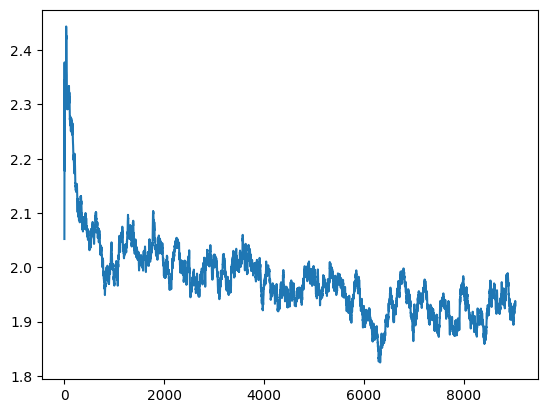

In [ ]:
for i in trange(0, epoches):
  print("epoch ", i, "/", epoches)
  losses = []
  val_losses = []
  trainModel(batch_size                = batch_size,
             checkpoint_steps          = checkpoint_steps,
             steps                     = int(len(train_all_sentences) / batch_size),
             # steps                     = 10,
             data_train                = train_all_sentences,
             model_path                = MODEL_PATH_QM_ALL,
             data_validation           = None,
             n_non_improve_val_perplex = None,
             val_amount_test           = None,
             random_batch              = False)


pd.Series(losses).ewm(100).mean().plot();

### 7.3.TRAINING ONE -----------------------------


In [ ]:
cleanup()

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_PATH_QM_ALL) # MODEL_PATH_RAW
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ALL) # MODEL_PATH_RAW

if torch.cuda.is_available():
    model.cuda()

fixTokenizer(tokenizer)
print(tokenizer.convert_ids_to_tokens([262923, 262924, 262925])) # ['zul_Latn', 'krc_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'krc_Cyrl', '<mask>'])) # [262923, 262924, 262925]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


['zul_Latn', 'krc_Cyrl', '<mask>']
[262923, 262924, 262925]


In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)

model.train()

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(262926, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(262926, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

In [ ]:
losses = []
val_losses = []

batch_size = 16 # 16
checkpoint_steps = 1000 # 1
n_non_improve_val_perplex = 50 # 28 # Number of subsequent training checkpoints if there is no improvement in validation perplexity
val_amount_test = 100 # Number of tests for validation 50
len_by_batch = int(len(train_one) / batch_size)
multiplicator = 7

In [ ]:
len_by_batch

4567

In [ ]:
trainModel(batch_size                = batch_size,
           checkpoint_steps          = checkpoint_steps,
           n_non_improve_val_perplex = n_non_improve_val_perplex, # Number of subsequent training checkpoints if there is no improvement in validation perplexity
           val_amount_test           = val_amount_test, # Number of tests for validation
           # steps                     = 10,
           steps                     = len_by_batch * multiplicator,
           data_train                = train_one,
           data_validation           = valid_one,
           model_path                = MODEL_PATH_QM_ONE,
           random_batch              = True)


pd.Series(losses).ewm(100).mean().plot();

  0%|          | 0/31969 [00:00<?, ?it/s]

Step: 0 / 31969 ; loss: 1.4511293172836304 ; validation loss: 10.663546447753907 ; perplexity: 4.267931643594124 ; validation perplexity: 68607.22437284573
Save model
Step: 1000 / 31969 ; loss: 1.2677779043316841 ; validation loss: 11.138845567703248 ; perplexity: 3.74965911042281 ; validation perplexity: 127791.59604670704
Step: 2000 / 31969 ; loss: 1.2354988691210746 ; validation loss: 10.813636798858642 ; perplexity: 3.597857872011414 ; validation perplexity: 107868.37130664168
Step: 3000 / 31969 ; loss: 1.224908717095852 ; validation loss: 10.470326218605042 ; perplexity: 3.55866885868019 ; validation perplexity: 97935.0283381306
Step: 4000 / 31969 ; loss: 1.1766925030350686 ; validation loss: 10.75149619102478 ; perplexity: 3.3826288128933317 ; validation perplexity: 95620.63484917647
Step: 5000 / 31969 ; loss: 1.174225578725338 ; validation loss: 10.54413655757904 ; perplexity: 3.3926398427822404 ; validation perplexity: 68488.59055041036
Save model
Step: 6000 / 31969 ; loss: 1.1

In [ ]:
pd.Series(val_losses).ewm(100).mean().plot();

In [ ]:
#tokenizer.save_pretrained(MODEL_PATH_QM_ONE)
#model.save_pretrained(MODEL_PATH_QM_ONE)
tokenizer.save_pretrained(MODEL_PATH_QM_ONE_FULL)
model.save_pretrained(MODEL_PATH_QM_ONE_FULL)

NameError: name 'tokenizer' is not defined

### 7.4.TRAINING SEVERAL (Unused) --------------------

In [ ]:
cleanup()

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_PATH_QM_ONE) # MODEL_PATH_RAW
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ONE) # MODEL_PATH_RAW

if torch.cuda.is_available():
    model.cuda()

fix_tokenizer(tokenizer)
print(tokenizer.convert_ids_to_tokens([262923, 262924, 262925])) # ['zul_Latn', 'krc_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'krc_Cyrl', '<mask>'])) # [262923, 262924, 262925]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['zul_Latn', 'krc_Cyrl', '<mask>']
[262923, 262924, 262925]


In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)

model.train()

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(262926, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(262926, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

In [ ]:
losses = []
val_losses = []

In [ ]:
batch_size = 8 # 2
checkpoint_steps = 500 # 1
n_non_improve_val_perplex = 16 # Number of subsequent training checkpoints if there is no improvement in validation perplexity
val_amount_test = 50 # Number of tests for validation
multiplicator = 8

  0%|          | 0/4168 [00:00<?, ?it/s]

Step: 0 / 4168 ; loss: 0.4571554958820343 ; validation loss: 9.235904722213744 ; perplexity: 1.5795744824815816 ; validation perplexity: 22005.860061041607
Save model
Step: 500 / 4168 ; loss: 0.5535339382886887 ; validation loss: 8.240299978256225 ; perplexity: 1.7721617839814015 ; validation perplexity: 8473.18029219669
Save model
Step: 1000 / 4168 ; loss: 0.4826882789134979 ; validation loss: 8.584512453079224 ; perplexity: 1.6458273131412497 ; validation perplexity: 12024.880017198771
Step: 1500 / 4168 ; loss: 0.4492411629259586 ; validation loss: 8.504578800201417 ; perplexity: 1.5932398338531661 ; validation perplexity: 9810.724474110817
Step: 2000 / 4168 ; loss: 0.40831055365502833 ; validation loss: 9.647112007141112 ; perplexity: 1.53055237995154 ; validation perplexity: 53585.410255662966
Step: 2500 / 4168 ; loss: 0.3641629644334316 ; validation loss: 9.69720067024231 ; perplexity: 1.458705261174111 ; validation perplexity: 55379.07346237168
Step: 3000 / 4168 ; loss: 0.3311686

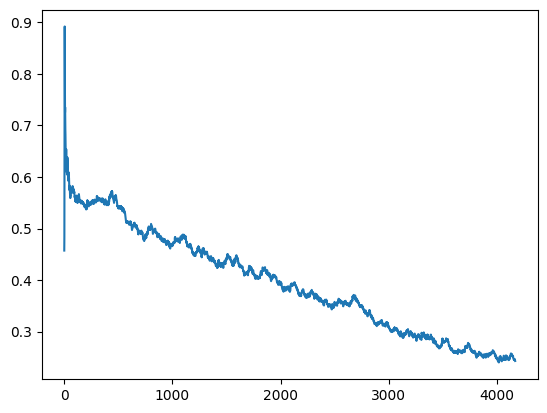

In [ ]:
trainModel(batch_size                = batch_size,
           checkpoint_steps          = checkpoint_steps,
           n_non_improve_val_perplex = n_non_improve_val_perplex, # Number of subsequent training checkpoints if there is no improvement in validation perplexity
           val_amount_test           = val_amount_test, # Number of tests for validation
           # steps                     = 10,
           steps                     = int(len(train_sev) / batch_size) * multiplicator,
           data_train                = train_sev,
           data_validation           = valid_sev,
           model_path                = MODEL_PATH_QM_SEV,
           random_batch              = True)


pd.Series(losses).ewm(100).mean().plot();

# 8.EVALUATION -----------------------------

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(SOURCE_MODEL) # MODEL_PATH_RAW
fixTokenizer(tokenizer)

sentencepiece.bpe.model:   0%|          | 0.00/5.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model_original = AutoModelForSeq2SeqLM.from_pretrained(SOURCE_MODEL)
model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ONE)
#model_finetuned_full = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ONE_FULL)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ONE)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
model_finetuned_full = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ONE_FULL)

In [ ]:
if torch.cuda.is_available():
    model_original.cuda()
    model_finetuned.cuda()
    #model_finetuned_full.cuda()

In [ ]:
def translate(model_input,
    text, src_lang='rus_Cyrl', tgt_lang='eng_Latn',
    a=32, b=3, max_input_length=1024, num_beams=4, **kwargs
):
    """Turn a text or a list of texts into a list of translations"""
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
    model_input.eval() # turn off training mode
    result = model_input.generate(
        **inputs.to(model_input.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams, **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

Example usage:

In [ ]:
t = 'Иш къолай болсун'
print(translate(model_input=model_original, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))
print(translate(model_input=model_finetuned, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))
#print(translate(model_input=model_finetuned_full, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))

['Пусть работа ваша будет успешной']
['Пусть работа ваша будет к добру']


In [ ]:
df = test_sev.sample(1)[['krc', 'rus']]
qm = df.krc.to_list()
ru = df.rus.to_list()
print(qm)
print(ru)

['«Qалай болсун?» – деb аталай сорады, махалайgа былай айтыb qояды: – Qамичими мында эгенни qолуна берирсе, сора, келиb, ол не айтханын билдирирсе. Махалай qамичини ол эгенnе бергенди, аталайны тутушуруgун аны бла билдиргенди. – Аталай–батыр деген таw аллындан келгенди, qап таwундан бизге салам бергенди. Аны тутушур белгиси буду, – деb, айтды халqgа эген, кюлюмсюреb.']
['Махалай пошел и отдал плеть тому судье, дав понять, что аталай тоже будет бороться. – Аталай–батыр приехал из предгорья, привез нам приветствие от каф–тау. Знак его желания бороться – это, – сказал судья народу, посмеиваясь. Когда встало солнце, вышли два борца, и начали нещадно мять друг друга. От усталости они скоро обмякли, их лица побледнели, осунулись.']


In [ ]:
qm = ["Алауган улу Къарашауай Минги Тауну башында джашагъанды. Минги Тауну айрысында джерни къазыб, бир ариу чокъракъ суу чъаргъанды. Минги Тауну елмез къара суу дегенлери олду."]
ru = ["Сын Алаучана Къарашауай жил на вершине горы Эльбрус. На перевале у Эльбруса он выкопал яму и оттуда забили красивые, чистые, прозрачные воды. Это те самые бессмертные воды Эльбруса."]

In [ ]:
print(ru)

['Сын Алаучана Къарашауай жил на вершине горы Эльбрус. На перевале у Эльбруса он выкопал яму и оттуда забили красивые, чистые, прозрачные воды. Это те самые бессмертные воды Эльбруса.']


In [ ]:
res1 = translate(model_input=model_original, text=qm, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl')
res2 = translate(model_input=model_finetuned, text=qm, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl')
#res3 = translate(model_input=model_finetuned_full, text=qm, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl')
print(res1)
print(res2)
#print(res3)
print(bleu_calc.corpus_score(res1, [ru]).score)
print(bleu_calc.corpus_score(res2, [ru]).score)
#print(bleu_calc.corpus_score(res3, [ru]).score)
print(chrf_calc.corpus_score(res1, [ru]).score)
print(chrf_calc.corpus_score(res2, [ru]).score)
#print(chrf_calc.corpus_score(res3, [ru]).score)

['Карашауай, сын алаугана, джашался на вершине Минги-тау. На краю Минги-тау источником источников из красавиц, источников, что называется неизбывная черная вода.']
['Къарашауай, сын алаугана, жил на вершине Минги-тау. На развилке Минги-тау обрушился обрыв, пролилась красивая родниковая река. Это и есть бессмертная родниковая река Минги-тау.']
3.5902192083202182
7.0174097821371095
19.740451228862856
29.6977467724717


In [ ]:
res1 = translate(model_input=model_original, text=ru, src_lang='rus_Cyrl', tgt_lang='krc_Cyrl')
res2 = translate(model_input=model_finetuned, text=ru, src_lang='rus_Cyrl', tgt_lang='krc_Cyrl')
#res3 = translate(model_input=model_finetuned_full, text=ru, src_lang='rus_Cyrl', tgt_lang='krc_Cyrl')
print(res1)
print(res2)
#print(res3)
print(bleu_calc.corpus_score(res1, [qm]).score)
print(bleu_calc.corpus_score(res2, [qm]).score)
#print(bleu_calc.corpus_score(res3, [qm]).score)
print(chrf_calc.corpus_score(res1, [qm]).score)
print(chrf_calc.corpus_score(res2, [qm]).score)
#print(chrf_calc.corpus_score(res3, [qm]).score)

['Аланны jашы Qарашаwай Миnи таwну башында jашаgанды. Миnи таwну аwушунда уруну qазgанды да, андан ариw, таза, чуwаq суwла qуйgанды. Ала Миnи таwну ёмюрлюк суwларыдыла.']
['Алаwну jашы Qарашаwай Эльбрус таwну башында jашаgанды. Эльбрус аwушда ол бир уру qазgанды да, андан ариw, таза, чуwаq суwла qуйgанды. Ала - Миnи таwну ёлмез суwлары.']
1.8564670505078418
1.8154533256373546
19.773058800224
18.864822664871397


In [ ]:
t = 'Иш къолай болсун'
print(translate(model_input=model_original, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))
print(translate(model_input=model_finetuned, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))
#print(translate(model_input=model_finetuned_full, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))
# ['Да будет работа успешной']

['Пусть работа ваша будет успешной']
['Пусть работа ваша будет к добру']


Analyze

In [ ]:
def modelColumn(model_name, data):
  df_cur = pd.DataFrame(data = {'model': [model_name] * len(data)})
  df_cur.reset_index(drop=True, inplace=True)
  data.reset_index(drop=True, inplace=True)
  return pd.concat([df_cur, data], axis=1)


def uniteData(model_name, datas):
  return pd.concat([modelColumn(model_name = model_name, data = i) for i in datas], axis=0)

def translateByData(model_name, model_input, datas, lg1 = "krc", lg2 = 'rus', lg1_writing = "Cyrl", lg2_writing = "Cyrl"):
  df = uniteData(model_name, datas)
  from_to1 = "".join([lg1, '2', lg2])
  from_to2 = "".join([lg2, '2', lg1])
  lang1 = "".join([lg1, '_', lg1_writing])
  lang2 = "".join([lg2, '_', lg2_writing])

  df[from_to1] = [translate(model_input, t, lang1, lang2)[0] for t in tqdm(df[lg1])]
  df[from_to2] = [translate(model_input, t, lang2, lang1)[0] for t in tqdm(df[lg2])]

  return df

In [ ]:
RANDOM_VALS = 250
#data_vec = [test_all.copy().sample(RANDOM_VALS), test_one.copy().sample(RANDOM_VALS), test_sev.copy().sample(RANDOM_VALS)]
data_vec = [test_all.copy().sample(RANDOM_VALS), test_one.copy().sample(RANDOM_VALS)]

In [ ]:
df_all = translateByData(model_name="model_original", datas=data_vec, model_input=model_original)
df_one = translateByData(model_name="model_finetuned", datas=data_vec, model_input=model_finetuned)
#df_full = translateByData(model_name="model_finetuned_full", datas=data_vec, model_input=model_finetuned)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
df_one = translateByData(model_name="model_finetuned", datas=data_vec, model_input=model_finetuned)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
df_full = translateByData(model_name="model_finetuned_full", datas=data_vec, model_input=model_finetuned_full)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
#df_all_all = pd.concat([df_all, df_one, df_full], axis=0)
df_all_all = pd.concat([df_one, df_full], axis=0)
df_all_all.reset_index(drop=True, inplace=True)

Result

In [ ]:
df_all_all["blue_rus"] = [bleu_calc.corpus_score([df_all_all["krc2rus"][x]], [[df_all_all['rus'][x]]]).score for x in df_all_all.index]
df_all_all["blue_krc"] = [bleu_calc.corpus_score([df_all_all["rus2krc"][x]], [[df_all_all['krc'][x]]]).score for x in df_all_all.index]
df_all_all["chrf_rus"] = [chrf_calc.corpus_score([df_all_all["krc2rus"][x]], [[df_all_all['rus'][x]]]).score for x in df_all_all.index]
df_all_all["chrf_krc"] = [chrf_calc.corpus_score([df_all_all["rus2krc"][x]], [[df_all_all['krc'][x]]]).score for x in df_all_all.index]

In [ ]:
df_all_all.copy().groupby("model")[['blue_rus', 'blue_krc', "chrf_rus", "chrf_krc"]].median()

,blue_rus,blue_krc,chrf_rus,chrf_krc
model,,,,
model_finetuned,6.831224,7.462720,37.227359,41.247301
model_finetuned_full,9.652435,7.139828,43.400465,43.654144


In [ ]:
df_all_all.to_csv("".join([PATH, "Data/result.csv"]))

In [ ]:
def fromModel(str, dialect = "qrc"):
  if dialect == "qrc":
      str = str.replace("тюйюл", "тюл")
      str = str.replace("Тюйюл", "Тюл")
      str = str.replace("уку", "гылын  qуш")
      str = str.replace("Уку", "Гылын  qуш")
      str = str.replace("хораз", "гугурукку")
      str = str.replace("Хораз", "Гугурукку")
      str = str.replace("юзмез", "qум")
      str = str.replace("Юзмез", "Qум")
      str = str.replace("jиля", "jыла")
      str = str.replace("Jиля", "Jыла")
      str = str.replace("ярабий", "арабин")
      str = str.replace("арабий", "арабин")
      str = str.replace("Ярабий", "Арабин")
      str = str.replace("Арабий", "Арабин")
      str = str.replace("нтта", "нтда")
      str = str.replace("ртте", "ртде")
      str = str.replace("jамауат", "jамаgат")
      str = str.replace("jамаwат", "jамаgат")
      str = str.replace("Jамауат", "Jамаgат")
      str = str.replace("Jамаwат", "Jамаgат")
      str = str.replace("шуёх", "шох")
      str = str.replace("Шуёх", "Шох")
      str = str.replace("шёндю", "бусаgат")
      str = str.replace("Шёндю", "Бусаgат")
      str = str.replace("уgай", "оgай")
      str = str.replace("Уgай", "Оgай")
      # str = str.replace("терк", "тез")
      str = str.replace("саnа", "сенnе")
      str = str.replace("сеnе", "сенnе")
      str = str.replace("Саnа", "Сенnе")
      str = str.replace("Сеnе", "Сенnе")
      str = str.replace("маnа", "менnе")
      str = str.replace("меnе", "менnе")
      str = str.replace("Маnа", "Менnе")
      str = str.replace("Меnе", "Менnе")
      str = str.replace("аяq jол", "jахтана")
      str = str.replace("Аяq jол", "Jахтана")
      str = str.replace("сыbат", "сыфат")
      str = str.replace("Сыbат", "Сыфат")
      str = str.replace("b", "б")
      str = str.replace("q", "къ")
      str = str.replace("Q", "Къ")
      str = str.replace("g", "гъ")
      str = str.replace("G", "Гъ")
      str = str.replace("j", "дж")
      str = str.replace("J", "Дж")
      str = str.replace("w", "ў")
      str = str.replace("W", "Ў")
      str = str.replace("n", "нг")
      str = str.replace("N", "Нг")
  elif dialect == "hlm":
      str = str.replace("тюл", "тюйюл")
      str = str.replace("Тюл", "Тюйюл")
      str = str.replace("гылын  qуш", "уку")
      str = str.replace("Гылын  qуш", "Уку")
      str = str.replace("гугурукку", "хораз")
      str = str.replace("Гугурукку", "Хораз")
      str = str.replace("qум", "юзмез")
      str = str.replace("Qум", "Юзмез")
      str = str.replace("jыла", "jиля")
      str = str.replace("Jыла", "Jиля")
      str = str.replace("арабин", "ярабий")
      str = str.replace("арабий", "ярабий")
      str = str.replace("Арабин", "Ярабий")
      str = str.replace("Арабий", "Ярабий")
      str = str.replace("нтда", "нтта")
      str = str.replace("ртде", "ртте")
      str = str.replace("jамаgат", "jамаwат")
      str = str.replace("Jамаgат", "Jамаwат")
      str = str.replace("шох", "шуёх")
      str = str.replace("Шох", "Шуёх")
      str = str.replace("бусаgат", "шёндю")
      str = str.replace("Бусаgат", "Шёндю")
      str = str.replace("оgай", "уgай")
      str = str.replace("Оgай", "Уgай")
      str = str.replace("тез", "терк")
      str = str.replace("сенnе", "саnа")
      str = str.replace("сеnе", "саnа")
      str = str.replace("Сенnе", "Саnа")
      str = str.replace("Сеnе", "Саnа")
      str = str.replace("менnе", "маnа")
      str = str.replace("меnе", "маnа")
      str = str.replace("Менnе", "Маnа")
      str = str.replace("Меnе", "Маnа")
      str = str.replace("jахтана", "аяq jол")
      str = str.replace("Jахтана", "аяq jол")
      str = str.replace("хо", "хаw")
      str = str.replace("Хо", "Хаw")
      str = str.replace("сыbат", "сыфат")
      str = str.replace("Сыbат", "Сыфат")
      str = str.replace("b", "п")
      str = str.replace("q", "къ")
      str = str.replace("Q", "Къ")
      str = str.replace("g", "гъ")
      str = str.replace("G", "Гъ")
      str = str.replace("j", "ж")
      str = str.replace("J", "Ж")
      str = str.replace("w", "ў")
      str = str.replace("W", "Ў")
      str = str.replace("n", "нг")
      str = str.replace("N", "Нг")
  elif dialect == "mqr":
      str = str.replace("тюл", "тюйюл")
      str = str.replace("Тюл", "Тюйюл")
      str = str.replace("гылын  qуш", "уку")
      str = str.replace("Гылын  qуш", "Уку")
      str = str.replace("гугурукку", "хораз")
      str = str.replace("Гугурукку", "Хораз")
      str = str.replace("qум", "юзмез")
      str = str.replace("Qум", "Юзмез")
      str = str.replace("jыла", "jиля")
      str = str.replace("Jыла", "Jиля")
      str = str.replace("арабин", "ярабий")
      str = str.replace("арабий", "ярабий")
      str = str.replace("Арабин", "Ярабий")
      str = str.replace("Арабий", "Ярабий")
      str = str.replace("нтда", "нтта")
      str = str.replace("ртде", "ртте")
      str = str.replace("jамаgат", "jамаwат")
      str = str.replace("Jамаgат", "Jамаwат")
      str = str.replace("шох", "шуёх")
      str = str.replace("Шох", "Шуёх")
      str = str.replace("бусаgат", "шёндю")
      str = str.replace("Бусаgат", "Шёндю")
      str = str.replace("оgай", "уgай")
      str = str.replace("Оgай", "Уgай")
      str = str.replace("тез", "терк")
      str = str.replace("сенnе", "саnа")
      str = str.replace("сеnе", "саnа")
      str = str.replace("Сенnе", "Саnа")
      str = str.replace("Сеnе", "Саnа")
      str = str.replace("менnе", "маnа")
      str = str.replace("меnе", "маnа")
      str = str.replace("Менnе", "Маnа")
      str = str.replace("Меnе", "Маnа")
      str = str.replace("jахтана", "аяq jол")
      str = str.replace("Jахтана", "аяq jол")
      str = str.replace("хо", "хаw")
      str = str.replace("Хо", "Хаw")
      str = str.replace("сыbат", "сыфат")
      str = str.replace("Сыbат", "Сыфат")
      str = str.replace("b", "п")
      str = str.replace("q", "къ")
      str = str.replace("Q", "Къ")
      str = str.replace("g", "гъ")
      str = str.replace("G", "Гъ")
      str = str.replace("j", "з")
      str = str.replace("J", "З")
      str = str.replace("w", "ў")
      str = str.replace("W", "Ў")
      str = str.replace("n", "нг")
      str = str.replace("N", "Нг")
      str = str.replace("ч", "ц")
      str = str.replace("Ч", "Ц")
      str = str.replace("п", "ф")
      str = str.replace("П", "Ф")
      str = str.replace("къ|гъ", "х")
  return str


def toModel(str):
    str = str.replace("дж", "j")
    str = str.replace("Дж", "J")
    str = str.replace("ДЖ", "J")
    str = str.replace("ж", "j")
    str = str.replace("Ж", "J")
    str = str.replace("себеп", "себеb")
    str = str.replace("себеб", "себеb")
    str = str.replace("Себеп", "Себеb")
    str = str.replace("Себеб", "Себеb")
    str = str.replace("тюйюл", "тюл")
    str = str.replace("Тюйюл", "Тюл")
    str = str.replace("уку", "гылын qуш")
    str = str.replace("Уку", "Гылын qуш")
    str = str.replace("хораз", "гугурукку")
    str = str.replace("Хораз", "Гугурукку")
    str = str.replace("юзмез", "qум")
    str = str.replace("Юзмез", "Qум")
    str = str.replace("арап", "араb")
    str = str.replace("араб", "араb")
    str = str.replace("Арап", "Араb")
    str = str.replace("Араб", "Араb")
    str = str.replace("jиля", "jыла")
    str = str.replace("jыла", "jыла")
    str = str.replace("jыла", "jыла")
    str = str.replace("Jиля", "Jыла")
    str = str.replace("Jыла", "Jыла")
    str = str.replace("Jыла", "Jыла")
    str = str.replace("ярабий", "арабин")
    str = str.replace("арабий", "арабин")
    str = str.replace("Ярабий", "Арабин")
    str = str.replace("Арабий", "Арабин")
    str = str.replace("нтта", "нтда")
    str = str.replace("ртте", "ртде")
    str = str.replace("jамагъат", "jамаgат")
    str = str.replace("jамауат", "jамаgат")
    str = str.replace("jамагъат", "jамаgат")
    str = str.replace("jамауат", "jамаgат")
    str = str.replace("Jамагъат", "Jамаgат")
    str = str.replace("Jамауат", "Jамаgат")
    str = str.replace("Jамагъат", "Jамаgат")
    str = str.replace("Jамаўат", "Jамаgат")
    str = str.replace("шуёх", "шох")
    str = str.replace("Шуёх", "Шох")
    str = str.replace("шёндю", "бусаgат")
    str = str.replace("бусагъат", "бусаgат")
    str = str.replace("Шёндю", "Бусаgат")
    str = str.replace("Бусагъат", "Бусаgат")
    str = str.replace("угъай", "оgай")
    str = str.replace("огъай", "оgай")
    str = str.replace("Угъай", "Оgай")
    str = str.replace("Огъай", "Оgай")
    # str = str.replace("терк", "тез")
    # str = str.replace("терк", "тез")
    str = str.replace("санга", "сенnе")
    str = str.replace("сенге", "сенnе")
    str = str.replace("сеннге", "сенnе")
    str = str.replace("Санга", "Сенnе")
    str = str.replace("Сеннге", "Сенnе")
    str = str.replace("Сенге", "Сенnе")
    str = str.replace("манга", "менnе")
    str = str.replace("меннге", "менnе")
    str = str.replace("менге", "менnе")
    str = str.replace("Манга", "Менnе")
    str = str.replace("Меннге", "Менnе")
    str = str.replace("Менге", "Менnе")
    str = str.replace("аякъ jол", "jахтана")
    str = str.replace("аякъ jол", "jахтана")
    str = str.replace("jахтана", "jахтана")
    str = str.replace("jахтана", "jахтана")
    str = str.replace("Аякъ jол", "Jахтана")
    str = str.replace("Аякъ jол", "Jахтана")
    str = str.replace("Jахтана", "Jахтана")
    str = str.replace("Jахтана", "Jахтана")
    str = str.replace("къамж", "qамыzh")
    str = str.replace("къамыж", "qамыzh")
    str = str.replace("Къамж", "Qамыzh")
    str = str.replace("Къамыж", "Qамыzh")
    str = str.replace("къымыж", "qымыzh")
    str = str.replace("къымыж", "qымыzh")
    str = str.replace("Къымыж", "Qымыzh")
    str = str.replace("Къымыж", "Qымыzh")
    str = str.replace("хау", "хо")
    str = str.replace("хаў", "хо")
    str = str.replace("Хау", "Хо")
    str = str.replace("Хаў", "Хо")
    str = str.replace("уа", "wa")
    str = str.replace("ўа", "wa")
    str = str.replace("Уа", "Wa")
    str = str.replace("Ўа", "Wa")
    str = str.replace("п", "b")
    str = str.replace("б", "b")
    str = str.replace("къ", "q")
    str = str.replace("Къ", "Q")
    str = str.replace("КЪ", "Q")
    str = str.replace("гъ", "g")
    str = str.replace("Гъ", "G")
    str = str.replace("ГЪ", "G")
    str = str.replace("ц", "ч")
    str = str.replace("Ц", "Ч")
    str = str.replace("ф", "п")
    str = str.replace("сыпат", "сыфат")
    str = str.replace("Сыпат", "Сыфат")
    str = str.replace("Ф", "П")
    str = str.replace("(?<=[аыоуэеиёюя])у(?=[аыоуэеиёюя])|(?<=[аыоуэеиёюя])ў(?=[аыоуэеиёюя])|(?<=[АЫОУЭЕИЁЮЯ])у(?=[АЫОУЭЕИЁЮЯ])|(?<=[АЫОУЭЕИЁЮЯ])ў(?=[АЫОУЭЕИЁЮЯ])", "w")
    str = str.replace("(?<=[аыоуэеиёюя])у|(?<=[аыоуэеиёюя])ў|(?<=[АЫОУЭЕИЁЮЯ])у|(?<=[АЫОУЭЕИЁЮЯ])ў", "w")
    # str = str.replace("у(?=[аыоуэеиёюя])|ў(?=[аыоуэеиёюя])|у(?=[АЫОУЭЕИЁЮЯ])|ў(?=[АЫОУЭЕИЁЮЯ])", "w")
    # str = str.replace("У(?=[аыоуэеиёюя])|Ў(?=[аыоуэеиёюя])|У(?=[АЫОУЭЕИЁЮЯ])|Ў(?=[АЫОУЭЕИЁЮЯ])", "W")
    str = str.replace("zh", "ж")
    str = str.replace("нг", "n")
    str = str.replace("Нг", "  N")
    str = str.replace("НГ", "  N")
    return str

In [ ]:
qarcha = pd.read_fwf("".join([DATA_PATH, 'Къарча.txt']), header = None)

FileNotFoundError: [Errno 2] No such file or directory: 'TSjB/qarachay-malqar_russian_parallel_corpora_dialectic-freeКъарча.txt'

In [ ]:
qarcha_mbart = pd.read_fwf("".join([DATA_PATH, 'Къарча эски.txt']), header = None)

In [ ]:
qarcha["model_original"] = [translate(model_original, toModel(t), 'krc_Cyrl', 'rus_Cyrl')[0] for t in tqdm(qarcha[0])]
qarcha["model_finetuned"] = [translate(model_finetuned, toModel(t), 'krc_Cyrl', 'rus_Cyrl')[0] for t in tqdm(qarcha[0])]
qarcha["model_finetuned_full"] = [translate(model_finetuned_full, toModel(t), 'krc_Cyrl', 'rus_Cyrl')[0] for t in tqdm(qarcha[0])]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

In [ ]:
qarcha = pd.concat([qarcha, qarcha_mbart[0]], axis=1)

In [ ]:
qarcha.to_excel("".join([DATA_PATH, "qarcha.xlsx"]))

In [ ]:
df_all_all

,model,krc,rus,short_source,source,type,krc2rus,rus2krc,blue_rus,blue_krc,chrf_rus,chrf_krc
0,model_finetuned,Аны адреси быяgынлайды,У него адрес тот же,sozluk_biraz,Словарь,one_sentence,"Его адрес указывает, адрес указывает, адрес ук...",Аны jери бияgынлайды,0.794753,0.000000,7.619548,39.402763
1,model_finetuned,"Кел, эришейик, ким кимни озса да, кёрюрсе!","Давай посоревнуемся, увидишь, кто кого обгонит!",jomaq,"Сказки из приложения ""Джомакъла""",one_sentence,"Давай поборемся, увидишь, кто кого одолеет!","Кел, эришейик, кимни ким озса, кёрюрсе!",48.549177,37.582506,64.047041,74.007811
2,model_finetuned,л рубидий,рубидий,sozluk_bir,Словарь,one_word,рубидий,Рубидийни юлюшю,0.000000,0.000000,100.000000,38.127768
3,model_finetuned,Оgурлу адам ичиндеги оgурлу хазнасындан оgурлу...,Добрый человек из доброго сокровища выносит до...,injil,Новый завет,one_sentence,Добрый человек из доброго сокровища выносит до...,Оgурлу адам оgурлу хазнасындан оgурлулуq чыgар...,100.000000,46.090162,100.000000,78.176384
4,model_finetuned,разг салырgа,приставить,sozluk_bir,Словарь,one_word,поставить,салыb qоярgа,0.000000,0.000000,52.315315,19.933712
...,...,...,...,...,...,...,...,...,...,...,...,...
995,model_finetuned_full,"Эй–эй–эй, дюгерлиле сюдю терк башындан ары jет...","Эй–эй–эй, дигорские судьи с верховьев терека п...",alan,Аланский историко-героический эпос,one_sentence,"Эйэйэйэй, дигорские судьи быстро добрались све...","Эйэйэйэй, дюгерли тёреле терк башындан jетдиле...",17.186768,50.725686,47.013113,64.791350
996,model_finetuned_full,"Пилат а, баш дин qуллуqчуланы, тамадаланы эм х...","Пилат же, созвав первосвященников и начальнико...",injil,Новый завет,one_sentence,"Пилат же, созвав первосвященников и старейшин ...","Пилат а, баш дин qуллуqчуланы, тамадаланы эм х...",65.803701,100.000000,75.828784,100.000000
997,model_finetuned_full,Бош минутум jоqду,У меня нет ни одной свободной минуты,sozluk_biraz,Словарь,one_sentence,У меня нет ни одной свободной минуты,Бош минутум jоqду,100.000000,0.000000,100.000000,100.000000
998,model_finetuned_full,Гурушха этиb айтырgа,Говорить с укоризнаой,sozluk_biraz,Словарь,one_sentence,Говорить с упрёком,Гурушха этиb сёлеширге,0.000000,0.000000,52.314324,54.973708


In [ ]:
rus_text = ["Как дела?", "Я хочу купить несколько фруктов.", "Что надо чтобы получать много денег?", "Гулять под звёздным небом замечательно.", "Что расскажешь о себе?"]

In [ ]:
[fromModel(translate(model_finetuned_full, t, 'rus_Cyrl', 'krc_Cyrl')[0]) for t in tqdm(rus_text)]

  0%|          | 0/5 [00:00<?, ?it/s]

['Къалайса?',
 'Мен бир ненча кёгет сатыб алыргъа сюеме.',
 'Кёб ачха алыр ючюн не керекди?',
 'Джулдузла тюбюнде айланнган сейирди.',
 'Кесинги юсюнгден не айтырса?']

In [ ]:
[fromModel(translate(model_finetuned, t, 'rus_Cyrl', 'krc_Cyrl')[0]) for t in tqdm(rus_text)]

  0%|          | 0/5 [00:00<?, ?it/s]

['Къалайса?',
 'Мен бир ненча кёгет сатыб алыргъа сюеме.',
 'Кёб ачха алыргъа не керекди?',
 'Джулдузлу кёкню тюбюнде айланнган тамашалыкъды.',
 'Кесинги юсюнгден не айтырыкъса?']

In [ ]:
krc_text = ["Не хапарынг барды?", "Джангы машинам джашилди. Бек ариўду."]

In [ ]:
[translate(model_finetuned_full, toModel(t), 'krc_Cyrl', 'rus_Cyrl')[0] for t in tqdm(krc_text)]

  0%|          | 0/2 [00:00<?, ?it/s]

['Что ты имеешь в виду?', 'Моя новая машина зелена, очень красивая.']

In [ ]:
[translate(model_finetuned, toModel(t), 'krc_Cyrl', 'rus_Cyrl')[0] for t in tqdm(krc_text)]

  0%|          | 0/2 [00:00<?, ?it/s]

['Какие новости у тебя?', 'Моя новая машина зелена, очень красива.']